In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lasagne import layers as lasagne, nonlinearities as nl
from sknn.mlp import Classifier, Layer, Native
from pcfm import plot_confusion_matrix
from pfimp import plot_feature_importance
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import *
from imblearn.over_sampling import SMOTE
from pauroc import cal_auroc

/home/shining/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
/home/shining/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('all_in_one.csv')
df = pd.DataFrame.as_matrix(df)
# It seems there are NaNs in the dataset.. 
# And all of them are in column 3. The one with log(.)
df = df[~np.isnan(df).any(axis=1)]
X = df[:,0:6] # Our feature matrix
y = np.array(df[:,-1],dtype=np.int) # Our truth labels
idx = np.array(df[:,6],dtype=np.int) # our ID
clname = ['RFI','PULSAR']
# Whitening
X -= np.mean(X,axis=0)
X /= np.std(X,axis=0)

In [16]:
num_iterations = 1
k_fold = 5
smote = SMOTE(ratio=1.0)
# Hyper parameters
nnlayers = [Native(lasagne.DenseLayer, num_units=6, nonlinearity=nl.leaky_rectify),Native(lasagne.DenseLayer, num_units=6, nonlinearity=nl.leaky_rectify),Native(lasagne.DenseLayer, num_units=4, nonlinearity=nl.leaky_rectify),Layer('Softmax')]

## Neural Network

In [17]:
kf = StratifiedKFold(k_fold,shuffle=True)
## Ytest
mega_ytest = []
## NON-SMOTE
fimp  = [] # feature importances
prob  = [] # probability 
metrc = [] # recall scores
metpr = [] # precision scores
metll = [] # log-loss 
metac = [] # accuracy
metf1 = [] # F1-score
metmc = [] # Matthews correlation coefficient
metgm = [] # G-Mean
metcm = [] # Confusion matrix
metfp = [] # FPR
## SMOTE
sfimp  = [] # feature importances
sprob  = [] # probability
smetrc = [] # recall scores
smetpr = [] # precision scores
smetll = [] # log-loss 
smetac = [] # accuracy
smetf1 = [] # F1-score
smetmc = [] # Matthews correlation coefficient
smetgm = [] # G-Mean
smetcm = [] # Confusion matrix
smetfp = [] # FPR

In [18]:
for rc in xrange(num_iterations):
    print "[",rc,'] Iteration...Starting'
    for tr,te in kf.split(X,y):
        xtrain, xtest = X[tr], X[te]
        ytrain, ytest = y[tr], y[te]
        sxtrain, sytrain = smote.fit_sample(xtrain,ytrain)
        ##
        nn = Classifier(layers=nnlayers,learning_rule='adam',batch_size=32,
                        n_iter=750,valid_size=0.2,learning_rate=1e-3,n_stable=50)
        snn = Classifier(layers=nnlayers,learning_rule='adam',batch_size=32,
                        n_iter=750,valid_size=0.2,learning_rate=1e-3,n_stable=50)
        nn.fit(xtrain,ytrain)
        snn.fit(sxtrain, sytrain)
        ##
        ypredict = nn.predict(xtest)
        sypredict = snn.predict(xtest)
        ## NON-SMOTE
        prob.append(nn.predict_proba(xtest))
        metrc.append(recall_score(ytest,ypredict))
        metpr.append(precision_score(ytest,ypredict))
        metac.append(accuracy_score(ytest,ypredict))
        metf1.append(f1_score(ytest,ypredict))
        metll.append(log_loss(ytest,ypredict))
        metmc.append(matthews_corrcoef(ytest,ypredict))
        cmyy = confusion_matrix(ytest,ypredict)
        metcm.append(cmyy)
        specificity = (1.*cmyy[0,0])/(cmyy[0,0] + cmyy[0,1])
        metgm.append(np.sqrt(recall_score(ytest,ypredict)*specificity))
        metfp.append(1.*cmyy[0,1]/(cmyy[0,0]+cmyy[0,1]))
        ## SMOTE
        sprob.append(snn.predict_proba(xtest))
        smetrc.append(recall_score(ytest,sypredict))
        smetpr.append(precision_score(ytest,sypredict))
        smetac.append(accuracy_score(ytest,sypredict))
        smetf1.append(f1_score(ytest,sypredict))
        smetll.append(log_loss(ytest,sypredict))
        smetmc.append(matthews_corrcoef(ytest,sypredict))
        scmyy = confusion_matrix(ytest,sypredict)
        smetcm.append(scmyy)
        sspecificity = (1.*scmyy[0,0])/(scmyy[0,0] + scmyy[0,1])
        smetgm.append(np.sqrt(recall_score(ytest,sypredict)*sspecificity))
        smetfp.append(1.*scmyy[0,1]/(scmyy[0,0]+scmyy[0,1]))
        ##
        mega_ytest.append(ytest)

[ 0 ] Iteration...Starting
[(17775, 2)]
[(17775, 2)]
[(17775, 2)]
[(17775, 2)]
[(17775, 2)]
[(17775, 2)]
[(17775, 2)]
[(17775, 2)]
[(17774, 2)]
[(17774, 2)]
[(17774, 2)]
[(17774, 2)]
[(17774, 2)]
[(17774, 2)]
[(17774, 2)]
[(17774, 2)]
[(17774, 2)]
[(17774, 2)]
[(17774, 2)]
[(17774, 2)]


In [6]:
print "The recall score is    {0:0.4f} +/- {1:2.3f}".format(np.mean(metrc),np.std(metrc))
print "The precision score is {0:0.4f} +/- {1:2.3f}".format(np.mean(metpr),np.std(metpr))
print "The accuracy is        {0:0.4f} +/- {1:2.3f}".format(np.mean(metac),np.std(metac))
print "The f1 score is        {0:0.4f} +/- {1:2.3f}".format(np.mean(metf1),np.std(metf1))
print "The logloss score is   {0:0.4f} +/- {1:2.3f}".format(np.mean(metll),np.std(metll))
print "The MCC is             {0:0.4f} +/- {1:2.3f}".format(np.mean(metmc),np.std(metmc))
print "The G-Mean is          {0:0.4f} +/- {1:2.3f}".format(np.mean(metgm),np.std(metgm))
print "The FPR is             {0:2.4e} +/- {1:1.4e}".format(np.mean(metfp),np.std(metfp))

The recall score is    0.9915 +/- 0.007
The precision score is 0.9644 +/- 0.012
The accuracy is        0.9994 +/- 0.000
The f1 score is        0.9777 +/- 0.007
The logloss score is   0.0210 +/- 0.006
The MCC is             0.9775 +/- 0.007
The G-Mean is          0.9955 +/- 0.004
The FPR is             5.0011e-04 +/- 1.7200e-04


In [7]:
print "The recall score is    {0:0.4f} +/- {1:2.3f}".format(np.mean(smetrc),np.std(smetrc))
print "The precision score is {0:0.4f} +/- {1:2.3f}".format(np.mean(smetpr),np.std(smetpr))
print "The accuracy is        {0:0.4f} +/- {1:2.3f}".format(np.mean(smetac),np.std(smetac))
print "The f1 score is        {0:0.4f} +/- {1:2.3f}".format(np.mean(smetf1),np.std(smetf1))
print "The logloss score is   {0:0.4f} +/- {1:2.3f}".format(np.mean(smetll),np.std(smetll))
print "The MCC is             {0:0.4f} +/- {1:2.3f}".format(np.mean(smetmc),np.std(smetmc))
print "The G-Mean is          {0:0.4f} +/- {1:2.3f}".format(np.mean(smetgm),np.std(smetgm))
print "The FPR is             {0:2.4e} +/- {1:1.4e}".format(np.mean(smetfp),np.std(smetfp))

The recall score is    0.9985 +/- 0.003
The precision score is 0.9597 +/- 0.014
The accuracy is        0.9994 +/- 0.000
The f1 score is        0.9787 +/- 0.007
The logloss score is   0.0202 +/- 0.007
The MCC is             0.9786 +/- 0.007
The G-Mean is          0.9990 +/- 0.001
The FPR is             5.7254e-04 +/- 2.0512e-04


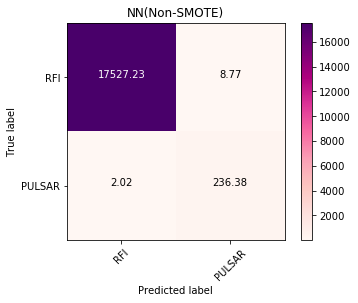

In [8]:
plot_confusion_matrix(np.mean(metcm,axis=0),clname,cmap=plt.cm.RdPu,title='NN(Non-SMOTE)',colmap=True)
plt.show()

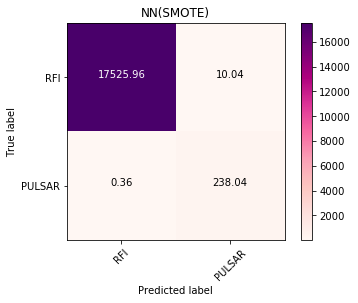

In [9]:
plot_confusion_matrix(np.mean(smetcm,axis=0),clname,cmap=plt.cm.RdPu,title='NN(SMOTE)',colmap=True)
plt.show()

In [10]:
np.min([x.shape[0] for x in prob]), np.min([x.shape[0] for x in sprob]), np.min([x.shape[0] for x in mega_ytest])

(17774, 17774, 17774)

In [11]:
hprob = np.array([x[:17774] for x in prob]) 
hsprob = np.array([x[:17774] for x in sprob])
hmega = np.array([x[:17774] for x in mega_ytest])

In [12]:
hprob.shape, hsprob.shape, hmega.shape

((100, 17774, 2), (100, 17774, 2), (100, 17774))

In [13]:
ret = cal_auroc(hmega,hprob,hsprob)

In [14]:
print "Non-SMOTE Mean AuROC {0:0.4f} +/- {1:2.5f}".format(ret['non_smote_auc'][0],ret['non_smote_auc'][1])
print "SMOTE Mean AuROC     {0:0.4f} +/- {1:2.5f}".format(ret['smote_auc'][0],ret['smote_auc'][1])

Non-SMOTE Mean AuROC 0.9949 +/- 0.00003
SMOTE Mean AuROC     0.9949 +/- 0.00002


In [15]:
import pickle
with open('nn_data.dat','wb') as f:
    pickle.dump([hmega,hprob,hsprob],f)